In [13]:
""" This notebook explores text generation with decoding strategies """
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import locale
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from tqdm.notebook import tqdm

In [2]:
%%capture

!sudo apt-get install graphviz graphviz-dev
!pip install transformers pygraphviz

locale.getpreferredencoding = lambda: "UTF-8"

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model.eval()

text = "I am a dog"
input_ids = tokenizer.encode(text, return_tensors='pt').to(device)

outputs = model.generate(input_ids, max_length=len(input_ids.squeeze())+5)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"Generated text: {generated_text}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated text: I am a dog lover. I love to


# Text Generation : Greedy Search

In [6]:
def get_log_prob(logits, token_id):
    """
    Compute the log probability of a token based on logits.

    :param logits: Predicted probabilities of tokens.
    :param token_id: Int ID of the token

    :return: log probability of the token.
    """
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    log_probabilities = torch.log(probabilities)
    token_log_probability = log_probabilities[token_id].item()
    return token_log_probability

In [8]:
def greedy_search(input_ids, node, length=5):
    """
    Perform greedy search to generate a sequence of tokens.

    :param input_ids: Input token IDs.
    :param node: Current node in the graph.
    :param length: Length of the sequence to generate

    :return: Input token IDs with additional tokens appended.
    """
    if length == 0:
        return input_ids

    outputs = model(input_ids)
    predictions = outputs.logits

    logits = predictions[0, -1, :]
    token_id = torch.argmax(logits).unsqueeze(0)

    token_score = get_log_prob(logits, token_id)
    new_input_ids = torch.cat([input_ids, token_id.unsqueeze(0)], dim=-1)

    next_token = tokenizer.decode(token_id, skip_special_tokens=True)
    current_node = list(graph.successors(node))[0]
    graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100
    graph.nodes[current_node]['token'] = next_token + f"_{length}"

    input_ids = greedy_search(new_input_ids, current_node, length-1)

    return input_ids

In [9]:
length = 5
beams = 1

graph = nx.balanced_tree(1, length, create_using=nx.DiGraph())

for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = 100
    graph.nodes[node]['token'] = text

output_ids = greedy_search(input_ids, 0, length=length)
output = tokenizer.decode(output_ids.squeeze().tolist(), skip_special_tokens=True)
print(f"Generated text: {output}")

Generated text: I am a dog lover. I love to


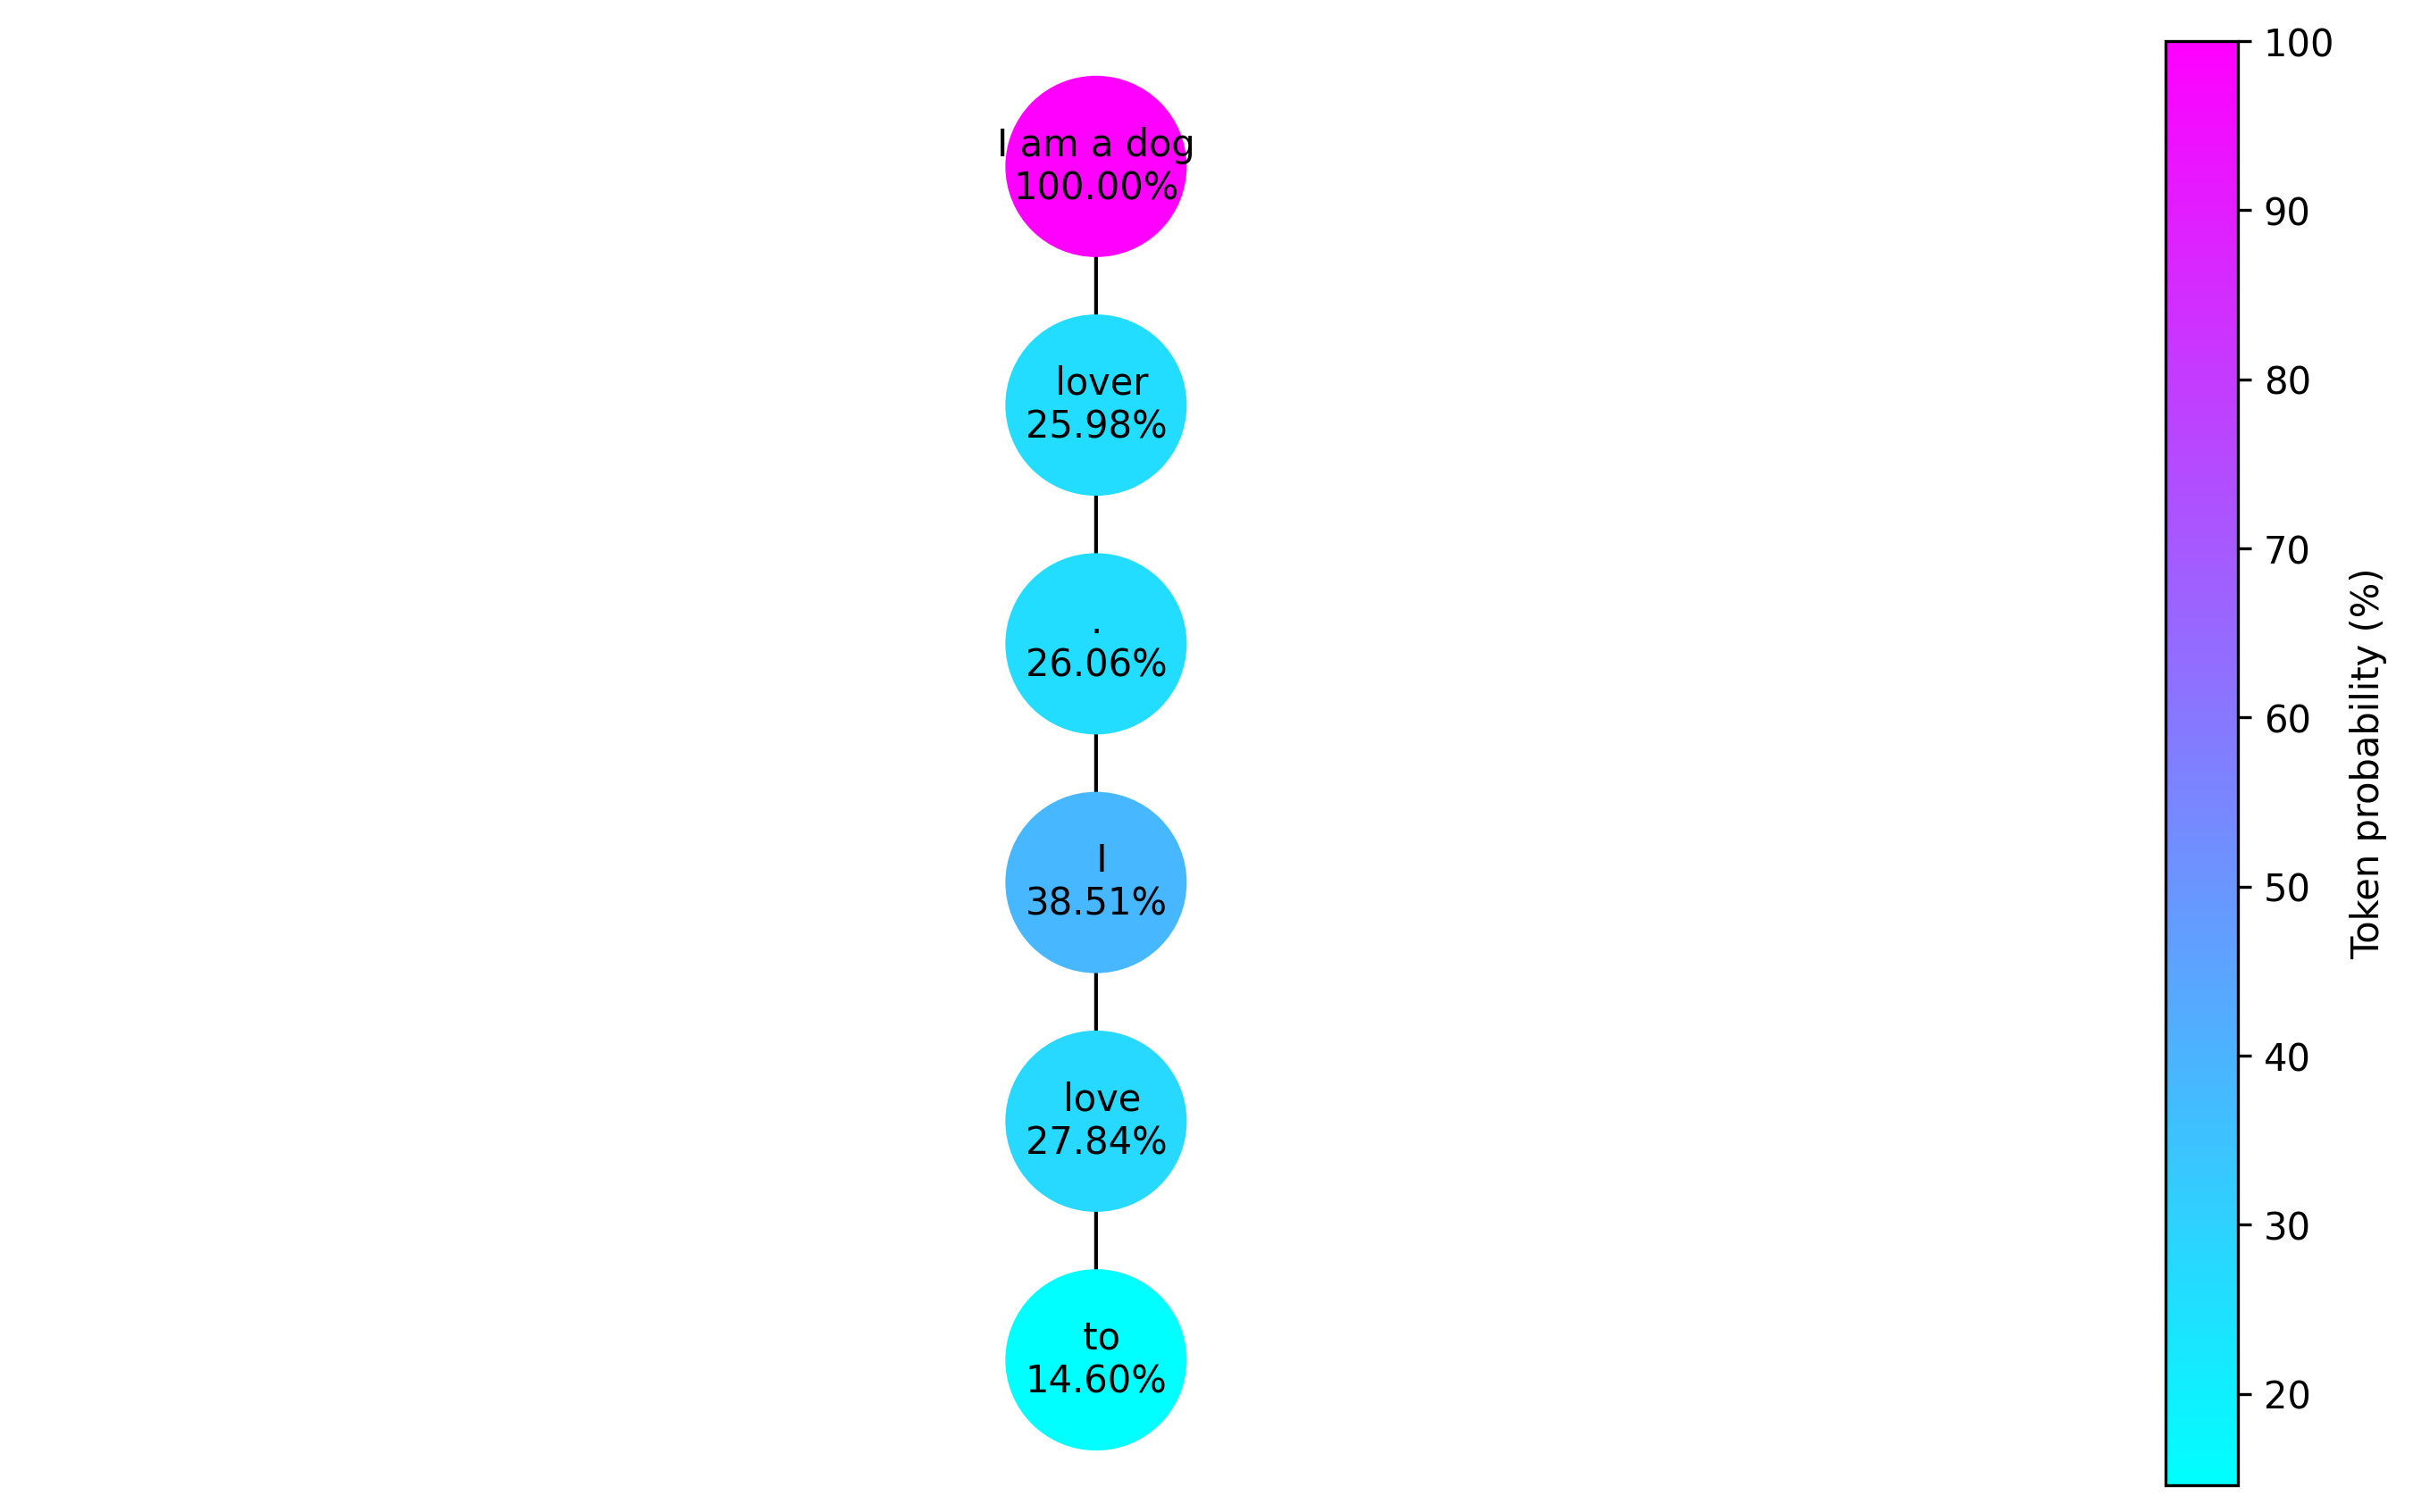

In [5]:
def plot_graph(graph, length, beams, score):
    """
    Plot a graph with nodes colored based on token or sequence scores.

    :param graph: NetworkX graph object representing the graph structure.
    :param length: Length of the graph (number of nodes).
    :param beams: Number of beams.
    :param score: Type of score to use for coloring nodes ('token' or 'sequence').

    :return: None
    """
    fig, ax = plt.subplots(figsize=(3+1.2*beams**length, max(5, 2+length)), dpi=300, facecolor='white')
    pos = nx.nx_agraph.graphviz_layout(graph, prog="dot")

    if score == 'token':
        scores = [data['tokenscore'] for _, data in graph.nodes(data=True) if data['token'] is not None]
    elif score == 'sequence':
        scores = [data['sequencescore'] for _, data in graph.nodes(data=True) if data['token'] is not None]
    vmin = min(scores)
    vmax = max(scores)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.cm.cool
    nx.draw_networkx_nodes(graph, pos, node_size=2000, node_shape='o', alpha=1, linewidths=4,
                          node_color=scores, cmap=cmap)
    nx.draw_networkx_edges(graph, pos)

    if score == 'token':
        labels = {node: data['token'].split('_')[0] + f"\n{data['tokenscore']:.2f}%" for node, data in graph.nodes(data=True) if data['token'] is not None}
    elif score == 'sequence':
        labels = {node: data['token'].split('_')[0] + f"\n{data['sequencescore']:.2f}" for node, data in graph.nodes(data=True) if data['token'] is not None}
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=10)
    plt.box(False)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    if score == 'token':
        fig.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Token probability (%)')
    elif score == 'sequence':
        fig.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Sequence score')
    plt.show()

plot_graph(graph, length, 1.5, 'token')

# Beam Search

In [10]:
def greedy_sampling(logits, beams):
    """
    Perform greedy sampling to select top-k token indices based on logits.

    :param logits: Logits representing the predicted probabilities of tokens.
    :param beams: Number of top token indices to select.

    :return: Top-k token indices.
    """
    return torch.topk(logits, beams).indices

In [11]:
def beam_search(input_ids, node, bar, length, beams, sampling, temperature=0.1):
    """
    Perform beam search to generate a sequence of tokens.

    :param input_ids: Input token IDs.
    :param node: Current node in the graph.
    :param bar: Progress bar.
    :param length: Length of the sequence to generate.
    :param beams: Number of beams.
    :param sampling: Type of sampling ('greedy', 'top_k', 'nucleus').
    :param temperature: Temperature parameter for sampling (default is 0.1).

    :return: None
    """
    if length == 0:
        return None

    outputs = model(input_ids)
    predictions = outputs.logits

    logits = predictions[0, -1, :]

    if sampling == 'greedy':
        top_token_ids = greedy_sampling(logits, beams)
    elif sampling == 'top_k':
        top_token_ids = top_k_sampling(logits, temperature, 20, beams)
    elif sampling == 'nucleus':
        top_token_ids = nucleus_sampling(logits, temperature, 0.5, beams)

    for j, token_id in enumerate(top_token_ids):
        bar.update(1)

        token_score = get_log_prob(logits, token_id)
        cumulative_score = graph.nodes[node]['cumscore'] + token_score
        new_input_ids = torch.cat([input_ids, token_id.unsqueeze(0).unsqueeze(0)], dim=-1)

        token = tokenizer.decode(token_id, skip_special_tokens=True)
        current_node = list(graph.successors(node))[j]
        graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100
        graph.nodes[current_node]['cumscore'] = cumulative_score
        graph.nodes[current_node]['sequencescore'] = 1/(len(new_input_ids.squeeze())) * cumulative_score
        graph.nodes[current_node]['token'] = token + f"_{length}_{j}"

        beam_search(new_input_ids, current_node, bar, length-1, beams, sampling, 1)

In [ ]:
length = 5
beams = 2

graph = nx.balanced_tree(beams, length, create_using=nx.DiGraph())
bar = tqdm(total=len(graph.nodes))

for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = 100
    graph.nodes[node]['cumscore'] = 0
    graph.nodes[node]['sequencescore'] = 0
    graph.nodes[node]['token'] = text

beam_search(input_ids, 0, bar, length, beams, 'greedy', 1)

In [15]:
def get_best_sequence(G):
    """
    Get the best sequence from the graph G based on sequence scores.

    :param G: NetworkX graph object representing the graph structure.

    :return: Tuple containing the best sequence and its corresponding score.
    """
    leaf_nodes = [node for node in G.nodes() if G.out_degree(node)==0]

    max_score_node = None
    max_score = float('-inf')
    for node in leaf_nodes:
        if G.nodes[node]['sequencescore'] > max_score:
            max_score = G.nodes[node]['sequencescore']
            max_score_node = node

    path = nx.shortest_path(G, source=0, target=max_score_node)
    sequence = "".join([G.nodes[node]['token'].split('_')[0] for node in path])

    return sequence, max_score


In [16]:
sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

Generated text: I am a dog lover. I love to


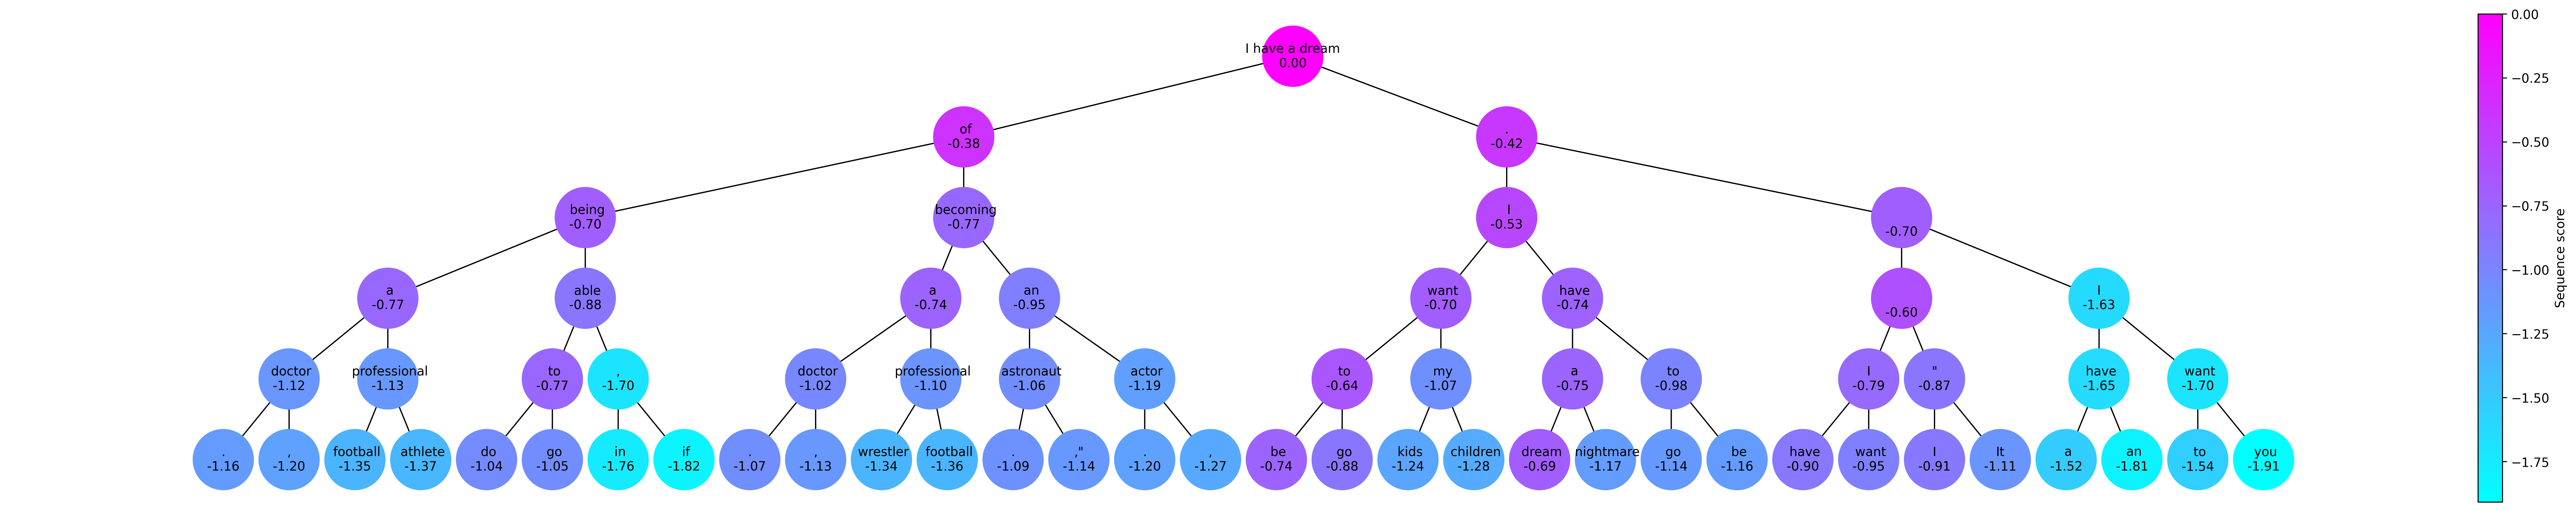

In [8]:

# Plot graph
plot_graph(graph, length, beams, 'sequence')

# Top-k Sampling

In [19]:
def plot_prob_distribution(probabilities, next_tokens, sampling, potential_nb, total_nb=50):
    """
    Plot the probability distribution of predicted tokens.

    :param probabilities: Predicted probabilities of tokens.
    :param next_tokens: Indices of selected tokens.
    :param sampling: Type of sampling ('top_k' or 'nucleus').
    :param potential_nb: Number of potential tokens to sample.
    :param total_nb: Total number of tokens to plot (default is 50).

    :return: None
    """
    top_k_prob, top_k_indices = torch.topk(probabilities, total_nb)
    top_k_tokens = [tokenizer.decode([idx]) for idx in top_k_indices.tolist()]

    next_tokens_list = [tokenizer.decode([idx]) for idx in next_tokens.tolist()]
    next_token_prob = probabilities[next_tokens].tolist()

    plt.figure(figsize=(0.4*total_nb, 5), dpi=300, facecolor='white')
    plt.rc('axes', axisbelow=True)
    plt.grid(axis='y', linestyle='-', alpha=0.5)
    if potential_nb < total_nb:
        plt.axvline(x=potential_nb-0.5, ls=':', color='grey', label='Sampled tokens')
    plt.bar(top_k_tokens, top_k_prob.tolist(), color='blue')
    plt.bar(next_tokens_list, next_token_prob, color='red', label='Selected tokens')
    plt.xticks(rotation=45, ha='right', va='top')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    if sampling == 'top_k':
        plt.title('Probability distribution of predicted tokens with top-k sampling')
    elif sampling == 'nucleus':
        plt.title('Probability distribution of predicted tokens with nucleus sampling')
    plt.legend()
    plt.savefig(f'{sampling}_{time.time()}.png', dpi=300)
    plt.close()


In [18]:
def top_k_sampling(logits, temperature, top_k, beams, plot=True):
    """
    Perform top-k sampling to select tokens based on logits.

    :param logits: Logits representing the predicted probabilities of tokens.
    :param temperature: Temperature parameter for sampling.
    :param top_k: Number of top tokens to consider.
    :param beams: Number of tokens to sample.
    :param plot: Whether to plot the probability distribution (default is True).

    :return: Indices of sampled tokens.
    """
    assert top_k >= 1
    assert beams <= top_k

    indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
    new_logits = torch.clone(logits)
    new_logits[indices_to_remove] = float('-inf')

    probabilities = torch.nn.functional.softmax(new_logits / temperature, dim=-1)

    next_tokens = torch.multinomial(probabilities, beams)

    if plot:
        total_prob = torch.nn.functional.softmax(logits / temperature, dim=-1)
        plot_prob_distribution(total_prob, next_tokens, 'top_k', top_k)

    return next_tokens

In [20]:
beam_search(input_ids, 0, bar, length, beams, 'top_k', 1)
sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

Generated text: I am a dog lover. I love the


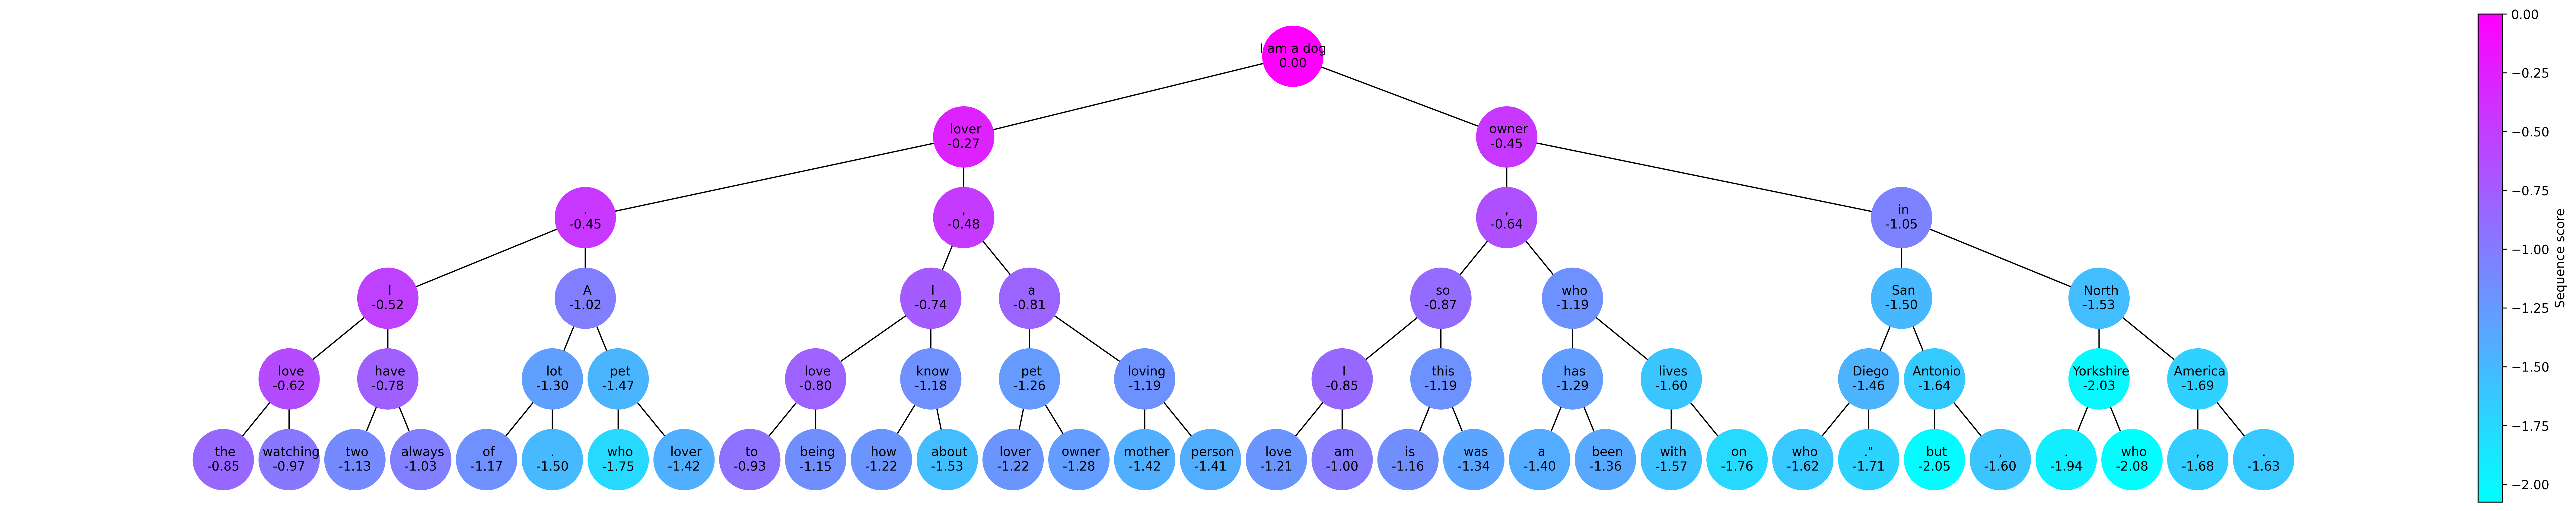

In [21]:
plot_graph(graph, length, beams, 'sequence')

# Nucleus Sampling

In [22]:
def nucleus_sampling(logits, temperature, p, beams, plot=True):
    """
    Perform nucleus sampling to select tokens based on logits.

    :param logits: Logits representing the predicted probabilities of tokens.
    :param temperature: Temperature parameter for sampling.
    :param p: Cumulative probability threshold for nucleus sampling (0 < p <= 1).
    :param beams: Number of tokens to sample.
    :param plot: Whether to plot the probability distribution (default is True).

    :return: Indices of sampled tokens.
    """
    assert p > 0
    assert p <= 1

    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    probabilities = torch.nn.functional.softmax(sorted_logits / temperature, dim=-1)
    cumulative_probabilities = torch.cumsum(probabilities, dim=-1)

    mask = cumulative_probabilities < p

    if mask.sum() > beams:
        top_p_index_to_keep = torch.where(mask)[0][-1].detach().cpu().tolist()
    else:
        top_p_index_to_keep = beams

    indices_to_remove = sorted_indices[top_p_index_to_keep:]
    sorted_logits[indices_to_remove] = float('-inf')

    probabilities = torch.nn.functional.softmax(sorted_logits / temperature, dim=-1)
    next_tokens = torch.multinomial(probabilities, beams)

    if plot:
        total_prob = torch.nn.functional.softmax(logits / temperature, dim=-1)
        plot_prob_distribution(total_prob, next_tokens, 'nucleus', top_p_index_to_keep)

    return next_tokens

In [23]:
beam_search(input_ids, 0, bar, length, beams, 'nucleus', 1)
sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")


Generated text: I am a dog. I am not a


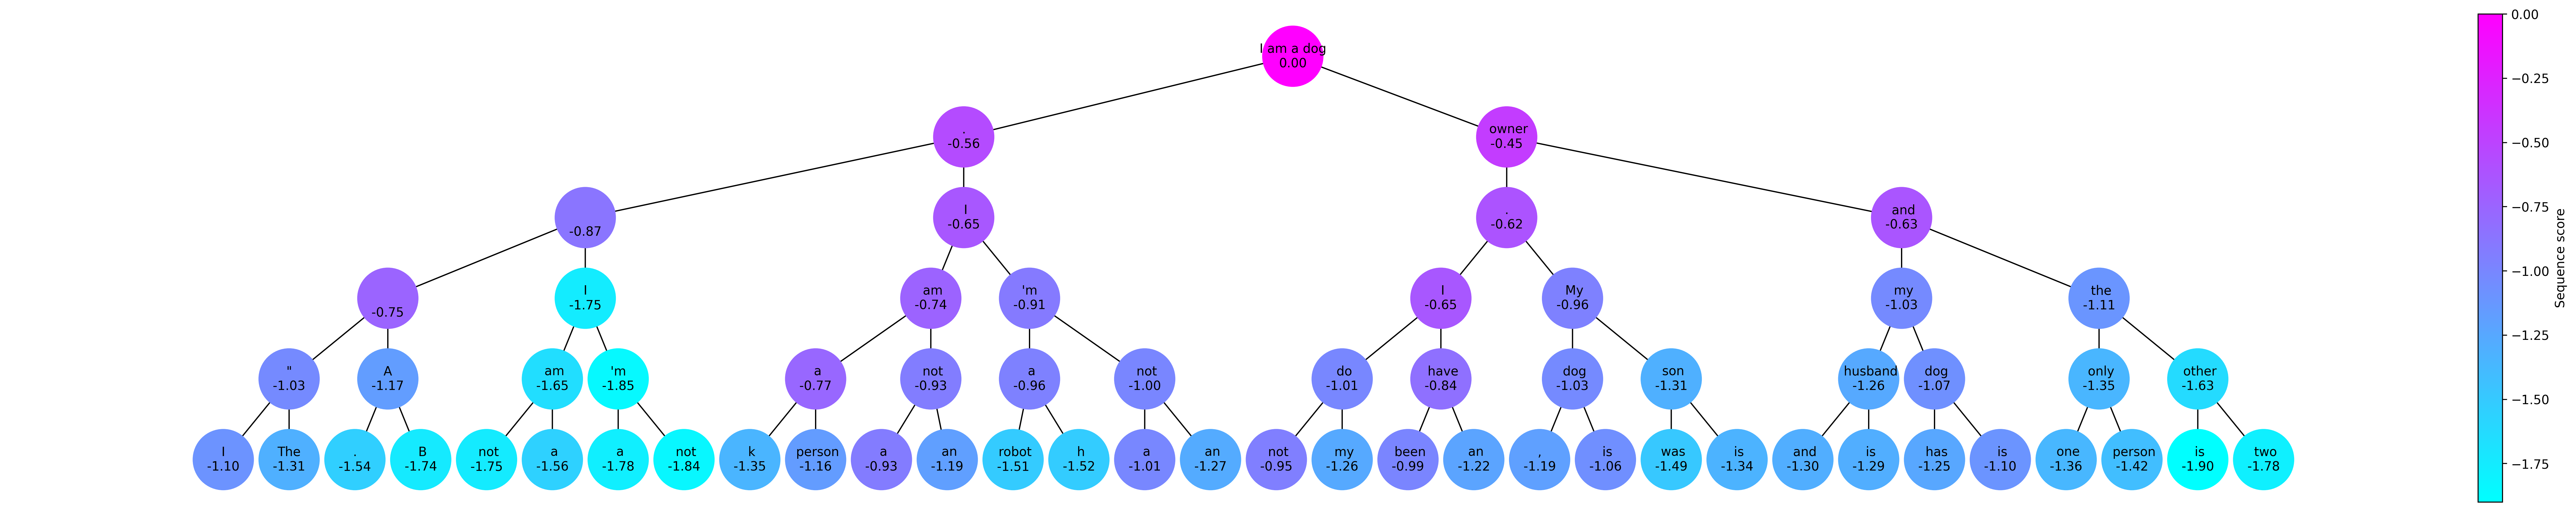

In [24]:
plot_graph(graph, length, beams, 'sequence')
